<a href="https://colab.research.google.com/github/stadanapisem/Sentiment-Analysis_SerbMR/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cPickle as pickle
import numpy as np
from sklearn import metrics
from sklearn import naive_bayes
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix, hstack
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import gensim

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Embedding, CuDNNGRU, LSTM, CuDNNLSTM, Flatten, Bidirectional, Dropout, Conv1D, MaxPool1D
from keras.initializers import Constant
from keras.optimizers import Adam, Adamax, SGD, RMSprop
from keras.utils import to_categorical
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

import warnings

%matplotlib inline
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Data Loading

* Loading the preprocessed input data. Preprocessing was done before due to the difficulties of running the neccessary tools on this platform. It consisted of a tokeniser and a lemmantiser.
* Loading the sentiment lexicon


In [0]:
!git clone https://github.com/stadanapisem/Sentiment-Analysis_SerbMR.git

Cloning into 'Sentiment-Analysis_SerbMR'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 6), reused 9 (delta 2), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [0]:
with open('Sentiment-Analysis_SerbMR/lemmantised_SerbMR-2C.p') as f:
  data2C = pickle.load(f)
  

In [0]:
with open('Sentiment-Analysis_SerbMR/lemmantised_SerbMR-3C.p') as f:
  data3C = pickle.load(f)

In [0]:
with open('Sentiment-Analysis_SerbMR/sr.lexicon') as f:
  lex = f.readlines()

lexicon = {}
for x in lex:
  x = x.split()
  lexicon[x[0].decode('utf8')] = int(x[1].strip())


#### Utilities

In [0]:
# from https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, normalize=True, figsize = (5,4), fontsize=14):
  """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

  Arguments
  ---------
  confusion_matrix: numpy.ndarray
      The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
      Similarly constructed ndarrays can also be used.
  class_names: list
      An ordered list of class names, in the order they index the given confusion matrix.
  figsize: tuple
      A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
      the second determining the vertical size. Defaults to (10,7).
  fontsize: int
      Font size for axes labels. Defaults to 14.

  Returns
  -------
  matplotlib.figure.Figure
      The resulting confusion matrix figure
  """
  if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
       
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names, 
  )
  fig = plt.figure(figsize=figsize)
  fmt = '.2f' if normalize else 'd'
  try:
      heatmap = sns.heatmap(df_cm, annot=True, fmt=fmt)
  except ValueError:
      raise ValueError("Confusion matrix values must be integers.")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  fig.tight_layout()
  plt.show()

## Train / Validation / Test split


In [0]:
def do_double_split(data, split):
  examples = []
  labels = []
  
  for row in data:
      examples.append(u' '.join(row[0]))
      labels.append(row[1])

  return train_test_split(examples, labels, train_size=split, shuffle=True, stratify=labels)

def do_tri_split(data):
  X_train, X_test, y_train, y_test = do_double_split(data, 0.65)
  X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, train_size=0.5, shuffle=True, stratify=y_test)

  return {
      'Xtrain' : X_train,
      'ytrain' : y_train,
      'Xval' : X_validation,
      'yval' : y_validation,
      'Xtst' : X_test,
      'ytst' : y_test
  }

In [0]:
data_2_class = do_tri_split(data2C)
data_3_class = do_tri_split(data3C)

# Experiment 001
Solution based only on the sentiment lexicon. The model is based on one parameter: limit. The average polarity of each sample is calculated (essentially wheather there are more positive or negative words). The prediction only takes into consideration if the calculated average is grater than the limit or not.


#### 2 Class

('Training F1:', 0.5724907063197026)
('Model limit:', 0.07540000000000073)
Evaluation
0.5816023738872403
[[118  50]
 [ 91  78]]
0.5252525252525252


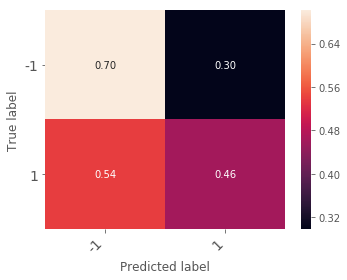

In [0]:
# LIMIT = 0.077

def run(data, LIMIT):
  results = []
  for row in data:
    words = row.split(' ')
    polarity = []
    for w in words:
      polarity.append(lexicon.get(w, 0))

    if np.mean(polarity) > LIMIT:
      results.append(1)
    else: results.append(-1)

  return results

data = do_double_split(data2C, 0.8)
# print(len(data[2]), len(data[0]))
max_acc = -1
res = -1

for LIMIT in np.arange(0.05, 0.1, 0.0002):
  results = run(data[0], LIMIT)
  acc = metrics.accuracy_score(data[2], results)

  if acc > max_acc:
    max_acc = acc
    res = LIMIT

print('Training accuracy:', max_acc)
print('Model limit:', res)

results = run(data[1], res)

print ('Evaluation')
print('Accuracy', metrics.accuracy_score(data[3], results))
# print(metrics.confusion_matrix(data[3], results))
print('F1 Score', metrics.f1_score(data[3], results))
  
print_confusion_matrix(metrics.confusion_matrix(data[3], results), ["-1", "1"])

#### 3 Class

('Training accuracy:', 0.3810703666997027)
('Model neg and pos limit:', 0.05800000000000002, 0.07800000000000001)
Evaluation
('Accuracy', 0.41188118811881186)


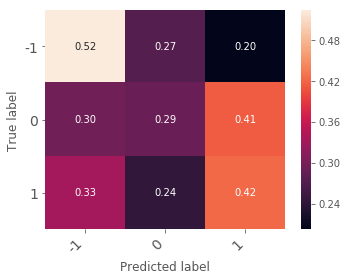

In [0]:
def run(data, posLIMIT, negLIMIT):
  results = []
  for row in data:
    words = row.split(' ')
    polarity = []
    for w in words:
      polarity.append(lexicon.get(w, 0))

    mean_pol = np.mean(polarity)
    if mean_pol >= posLIMIT:
      results.append(1)
    elif mean_pol <= negLIMIT: 
      results.append(-1)
    else:
      results.append(0)

  return results

# posLIMIT = 0.45
# negLIMIT = 0.05
data = do_double_split(data3C, 0.8)

max_acc = 0
res_min = -1
res_max = -1

for posLIMIT in np.arange(0.04, 0.15, 0.0005):
  for negLIMIT in np.arange(-0.1, 0.04, 0.005):
    results = run(data[0], posLIMIT, negLIMIT)

    acc = metrics.accuracy_score(data[2], results)
    
    if acc > max_acc:
      max_acc = acc
      res_min = negLIMIT
      res_max = posLIMIT
    
print('Training accuracy:', max_acc)
print('Model neg and pos limit:', res_min, res_max)
    
results = run(data[1], res_max, res_min)
    
print('Evaluation')
print('Accuracy', metrics.accuracy_score(data[3], results))
# print(metrics.confusion_matrix(data[3], results))
print_confusion_matrix(metrics.confusion_matrix(data[3], results), ["-1", "0", "1"])

# Experiment 002

Solution based only on the sentiment lexicon, however this time it takes into consideration the ratio of positive / negative and the total number of words in the example.

#### 2 Class

0.5


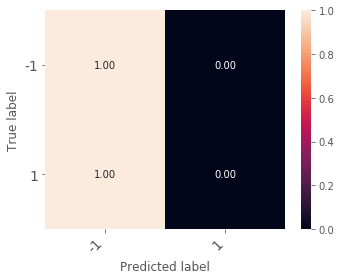

In [0]:
results = []
for row in data2C:
  words = row[0]
  polarity = []
  for w in words:
    polarity.append(lexicon.get(w, 0))
  
  counts = dict(zip(*np.unique(polarity, return_counts=True)))
#   print(counts)
  total_words = counts[-1] + counts[0] + counts[1]
  ratio_pos = counts[1] / total_words
  ratio_neg = counts[-1] / total_words
  
  if ratio_pos > ratio_neg:
    results.append(1)
  else: results.append(-1)
    
print(metrics.accuracy_score([x[1] for x in data2C], results))
# print(metrics.confusion_matrix([x[1] for x in data2C], results))
print_confusion_matrix(metrics.confusion_matrix([x[1] for x in data2C], results), ["-1", "1"])

#### 3 Class

0.3333333333333333


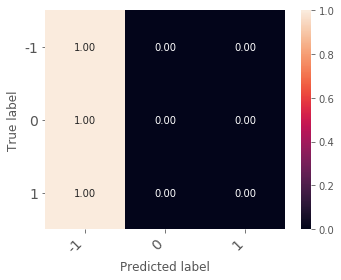

In [0]:
results = []
for row in data3C:
  words = row[0]
  polarity = []
  for w in words:
    polarity.append(lexicon.get(w, 0))
  
  counts = dict(zip(*np.unique(polarity, return_counts=True)))
#   print(counts)
  total_words = counts[-1] + counts[0] + counts[1]
  ratio_pos = counts[1] / total_words
  ratio_neg = counts[-1] / total_words
  
  if ratio_pos > ratio_neg:
    results.append(1)
  else: results.append(-1)
    
print(metrics.accuracy_score([x[1] for x in data3C], results))
# print(metrics.confusion_matrix([x[1] for x in data3C], results))
print_confusion_matrix(metrics.confusion_matrix([x[1] for x in data3C], results), ["-1", "0", "1"])

# Feature Extraction


In [0]:
def polarity_counts(data, posLIMIT, negLIMIT, skip = 1):
  words = data.split(' ')
  polarity = []
  for word in map(None, *(iter(words),) * skip):
    pol = []

    if skip == 1:
      word = [word]
      
    for w in word:
      if w:
        pol.append(lexicon.get(w, 0))
      else:
        break
    
    if np.mean(pol) >= posLIMIT:
      polarity.append(1)
    elif np.mean(pol) <= negLIMIT:
      polarity.append(-1)
    else:
      polarity.append(0)
  
  counts = dict(zip(*np.unique(polarity, return_counts=True)))
#   print(counts)
  return [counts.get(-1, 0), counts.get(0, 0), counts.get(1, 0)]

def create_feature_vector(data, posLIMIT, negLIMIT):
  features = []
  for example in data:
    features += [polarity_counts(example, posLIMIT, negLIMIT) + polarity_counts(example, posLIMIT, negLIMIT, skip=2) + polarity_counts(example, posLIMIT, negLIMIT, skip=3)]
    
  return np.array(features)
  

In [0]:
data = data_2_class

asd = create_feature_vector(data['Xtst'][:3], 0.004, 0.004)
print(asd)
# for feat in asd:
#   print feat

[[418   0  65 185   0  57 110   0  51]
 [280   0  35 125   0  33  73   0  32]
 [118   0  13  55   0  11  34   0  10]]


# Experiment 003
Baseline model using multinomial naive Bayes

Bag of words

0.5170068027210885
('Train accuracy', 0.5170068027210885)
Evaluation
0.5186440677966102
[[86 61]
 [81 67]]


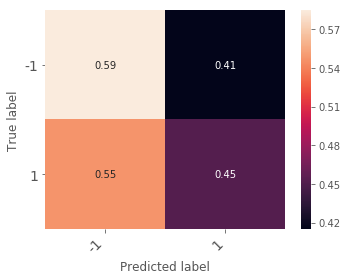

In [0]:
data = data_2_class.copy()

model = naive_bayes.MultinomialNB()

max_acc = 0
res = -1

for LIMIT in [0, 0.3, 0.5, 0.7]:
  X_train = create_feature_vector(data['Xtrain'], LIMIT, LIMIT)
  X_val = create_feature_vector(data['Xval'], LIMIT, LIMIT)
  
  model = model.fit(X=X_train, y=data['ytrain'])
  acc = metrics.accuracy_score(data['yval'], model.predict(X_val))
  print(acc)
  if acc > max_acc:
    max_acc = acc
    res = LIMIT

print('Train accuracy', max_acc)

X_train = create_feature_vector(data['Xtrain'], res, res)
model = model.fit(X=X_train, y=data['ytrain'])

X_tst = create_feature_vector(data['Xtst'], res, res)
predictions = model.predict(X_tst)

print('Evaluation')
print(metrics.accuracy_score(data['ytst'], predictions))
print(metrics.confusion_matrix(data['ytst'], predictions))
print_confusion_matrix(metrics.confusion_matrix(data['ytst'], predictions), ["-1", "1"])

#### 3 Class

In [0]:
data = data_3_class.copy()

model = naive_bayes.MultinomialNB()

max_acc = 0
res = -1

for posLIMIT in [0.03, 0.05, 0.0754, 0.097]:
  for negLIMIT in [-0.03, 0, 0.03, 0.058, 0.07]:
    if negLIMIT > posLIMIT:
      negLIMIT, posLIMIT = posLIMIT, negLIMIT

    X_train = create_feature_vector(data['Xtrain'], posLIMIT, negLIMIT)
    X_val = create_feature_vector(data['Xval'], posLIMIT, negLIMIT)

    model = model.fit(X=X_train, y=data['ytrain'])
    acc = metrics.accuracy_score(data['yval'], model.predict(X_val))
    if acc > max_acc:
      max_acc = acc
      res = (posLIMIT, negLIMIT)

print('Train accuracy', max_acc)

if res[1] > res[0]:
  res = (res[0], res[1])

X_train = create_feature_vector(data['Xtrain'], res[0], res[1])
model = model.fit(X=X_train, y=data['ytrain'])

X_tst = create_feature_vector(data['Xtst'], res[0], res[1])
predictions = model.predict(X_tst)

print('Evaluation')
print(metrics.accuracy_score(data['ytst'], predictions))
print(metrics.confusion_matrix(data['ytst'], predictions))
print_confusion_matrix(metrics.confusion_matrix(data['ytst'], predictions), ["-1", "0", "1"])

#### 2 Class

In [0]:
data = list(data2C)
# print(data2C[1][0])
vectoriser = CountVectorizer()
examples = vectoriser.fit_transform([u" ".join(x[0]) for x in data])
examples = hstack([examples, coo_matrix(create_feature_vector([" ".join(x[0]) for x in data], 0, 0))])

labels = [x[1] for x in data]
  
X_train, X_test, ytrain, ytest = train_test_split(examples, labels, train_size=0.8, shuffle=True, stratify=labels)
model = naive_bayes.MultinomialNB()


model = model.fit(X=X_train, y=ytrain)
y_pred = model.predict(X_test)

print(metrics.accuracy_score(ytrain, model.predict(X_train)))
print(metrics.accuracy_score(ytest, y_pred))

0.9977695167286246
0.7744807121661721


#### 3 Class

In [0]:
data = list(data3C)
# print(data2C[1][0])
vectoriser = CountVectorizer()
examples = vectoriser.fit_transform([u" ".join(x[0]) for x in data])
examples = hstack([examples, coo_matrix(create_feature_vector([" ".join(x[0]) for x in data], 0.01, 0.05))])

labels = [x[1] for x in data]
  
X_train, X_test, ytrain, ytest = train_test_split(examples, labels, train_size=0.65, shuffle=True, stratify=labels)
model = naive_bayes.MultinomialNB()


model = model.fit(X=X_train, y=ytrain)
y_pred = model.predict(X_test)

print(metrics.accuracy_score(ytrain, model.predict(X_train)))
print(metrics.accuracy_score(ytest, y_pred))

0.9975594874923734
0.5633484162895928


# Experiment 005

#### Common

In [0]:
def get_model(classes, data_all, data_with_separation, EMBEDDING_DIM, window, min_count):
  data = list(data_all)

  examples = [x[0] for x in data]

  word2vec = gensim.models.Word2Vec(sentences=examples, size=EMBEDDING_DIM, window=window, min_count=min_count, workers=2, iter=5)
  words = list(word2vec.wv.vocab)
  print('Vocabulary size:', len(words))
  # print(model.wv.most_similar('dobar'))

  word2vec.wv.save_word2vec_format('word2vec_' + str(classes) + '_class.txt')
  
  wordvectors = {}
  with open('word2vec_' + str(classes) + '_class.txt') as f:
    vocab_size = int(f.readline().split()[0])

    for line in f:
      vals = line.split()
      wordvectors[vals[0]] = np.asarray(vals[1:], dtype=np.float)

  data = data_with_separation.copy()
  tokenizer = Tokenizer()

  all_examples = data['Xtrain'] + data['Xtst'] + data['Xval']
  all_labels = list(map(lambda x: 0 if x == -1 else 1, data['ytrain'] + data['ytst'] + data['yval']))
  tokenizer.fit_on_texts(all_examples)
  seq = tokenizer.texts_to_sequences(all_examples)

  longest_example = max([len(x.split()) for x in all_examples])
  vocab_size = len(tokenizer.word_index) + 1

  seq_padded = pad_sequences(seq, maxlen=longest_example)

  print('Longest review', longest_example)
  print('Unique tokens', len(tokenizer.word_index))
  print('padded', seq_padded.shape)

  X_train = pad_sequences(tokenizer.texts_to_sequences(data['Xtrain']), maxlen=longest_example)
  X_tst = pad_sequences(tokenizer.texts_to_sequences(data['Xtst']), maxlen=longest_example)
  X_val = pad_sequences(tokenizer.texts_to_sequences(data['Xval']), maxlen=longest_example)

  if classes == 3:
    ytrain = to_categorical(data['ytrain'], num_classes=classes)
    ytst = to_categorical(data['ytst'], num_classes=classes)
    yval = to_categorical(data['yval'], num_classes=classes)
  else:
    ytrain = to_categorical(list(map(lambda x: 0 if x == -1 else 1, data['ytrain'])))
    ytst = to_categorical(list(map(lambda x: 0 if x == -1 else 1, data['ytst'])))
    yval = to_categorical(list(map(lambda x: 0 if x == -1 else 1, data['yval'])))
    
  embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM + 1))

  for word, i in tokenizer.word_index.items():
    if i > vocab_size:
      continue
    embd = wordvectors.get(word)
    if embd is not None:
      embedding_matrix[i] = np.append(embd, lexicon.get(word, 0))

  print ('Embedding size', np.shape(embedding_matrix))
  
  model = Sequential()
  embedding_layer = Embedding(vocab_size, EMBEDDING_DIM + 1, embeddings_initializer=Constant(embedding_matrix), input_length=longest_example, trainable=True)
  model.add(embedding_layer)
  model.add(Bidirectional(CuDNNLSTM(256)))
  model.add(Dropout(0.3))
  model.add(Dense(classes, activation='softmax'))
  adamax = Adamax(lr=0.0001)
  model.compile(loss='categorical_crossentropy', optimizer=adamax, metrics=['acc'])
  print(model.summary())
  return model, [X_train, X_tst, X_val, ytrain, ytst, yval]

def plot_acc(train_data):
  plt.plot(train_data.history['acc'], label='train')
  plt.plot(train_data.history['val_acc'], label='validation')
  plt.legend()
  plt.show()
  
def plot_loss(train_data):
  plt.plot(train_data.history['loss'], label='train')
  plt.plot(train_data.history['val_loss'], label='validation')
  plt.legend()
  plt.show()

#### 2 Class

In [0]:
data = list(data2C)

EMBEDDING_DIM = 300

examples = [x[0] for x in data]

model = gensim.models.Word2Vec(sentences=examples, size=EMBEDDING_DIM, window=3, min_count=10, workers=2, iter=5)
words = list(model.wv.vocab)
print(len(words))
print(model.wv.most_similar('dobar'))

model.wv.save_word2vec_format('word2vec_2_class.txt')

6299
[(u'lo\u0161', 0.9456838369369507), (u'zanimljiv', 0.8770398497581482), (u'zabavan', 0.8606915473937988), (u'sjajan', 0.8598860502243042), (u'kvalitetan', 0.8296142816543579), (u'definitivno', 0.8127925992012024), (u'napisati', 0.8070793747901917), (u'bitan', 0.8052634000778198), (u'pomenuti', 0.8033238649368286), (u'originalan', 0.8026337623596191)]


In [0]:
wordvectors = {}
with open('word2vec_2_class.txt') as f:
  vocab_size = int(f.readline().split()[0])
  
  for line in f:
    vals = line.split()
    wordvectors[vals[0]] = np.asarray(vals[1:], dtype=np.float)

In [0]:
data = data_2_class.copy()
tokenizer = Tokenizer()

all_examples = data['Xtrain'] + data['Xtst'] + data['Xval']
all_labels = list(map(lambda x: 0 if x == -1 else 1, data['ytrain'] + data['ytst'] + data['yval']))
tokenizer.fit_on_texts(all_examples)
seq = tokenizer.texts_to_sequences(all_examples)

longest_example = max([len(x.split()) for x in all_examples])
vocab_size = len(tokenizer.word_index) + 1

seq_padded = pad_sequences(seq, maxlen=longest_example)

print('Unique tokens', len(tokenizer.word_index))
print('padded', seq_padded.shape)
# model.fit([x[0] for x in data2C[:5]], [x[1] for x in data2C[:5]], verbose=2)

('Unique tokens', 47236)
('padded', (1682, 1831))


In [0]:
print(seq[0], all_labels[0])
print(model.wv.most_similar(tokenizer.index_word.items()[1127][1]))
print(data['Xtrain'][0])

([9637, 23185, 13, 22, 354, 390, 8, 117, 120, 2929, 398, 8, 9, 117, 11, 1, 46, 29, 520, 57, 6, 1, 167, 16, 11, 691, 6, 1, 2568, 21, 75, 438, 9, 1, 111, 40, 147, 15, 7, 737, 35, 4284, 13, 9, 1094, 122, 6, 1, 2220, 15, 813, 34, 1, 9638, 13382, 9639, 108, 329, 1, 11, 70, 44, 112, 1, 1, 262, 45, 3, 77, 1, 1, 1140, 120, 373, 190, 23186, 2, 354, 1769, 752, 989, 20, 2, 5430, 8489, 348, 4, 7, 1, 140, 45, 3, 11, 4517, 2, 13, 13383, 100, 174, 49, 1, 89, 307, 40, 177, 19, 1, 27, 411, 208, 7, 467, 120, 78, 269, 60, 269, 66, 403, 12, 5, 251, 1, 3, 30, 707, 2655, 2, 168, 1635, 42, 33, 1, 166, 1280, 23187, 41, 33, 1, 30, 219, 2828, 4518, 9, 286, 2110, 1, 45, 790, 3, 682, 1153, 3, 1, 222, 1635, 28, 13, 78, 5090, 858, 20, 86, 1, 9, 802, 802, 1, 9, 12, 2, 8, 483, 7, 8490, 2, 123, 14, 59, 108, 1, 77, 9, 23188, 1736, 4, 36, 75, 7, 1, 5, 77, 17, 69, 1095, 77, 23, 163, 1005, 42, 6, 11166, 8491, 2, 23, 1400, 8, 6, 1, 23189, 2, 9, 1, 9, 56, 1, 23190, 247, 11, 12, 1, 247, 88, 1281, 1005, 42, 6, 1, 1770, 8, 10,

In [0]:
X_train = pad_sequences(tokenizer.texts_to_sequences(data['Xtrain']), maxlen=longest_example)
X_tst = pad_sequences(tokenizer.texts_to_sequences(data['Xtst']), maxlen=longest_example)
X_val = pad_sequences(tokenizer.texts_to_sequences(data['Xval']), maxlen=longest_example)

ytrain = to_categorical(list(map(lambda x: 0 if x == -1 else 1, data['ytrain'])))
ytst = to_categorical(list(map(lambda x: 0 if x == -1 else 1, data['ytst'])))
yval = to_categorical(list(map(lambda x: 0 if x == -1 else 1, data['yval'])))

In [0]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM + 1))

for word, i in tokenizer.word_index.items():
  if i > vocab_size:
    continue
  embd = wordvectors.get(word)
  if embd is not None:
#     print(type(embd))
    embedding_matrix[i] = np.append(embd, lexicon.get(word, 0))
    
print (np.shape(embedding_matrix))

(47237, 301)


In [104]:
model = Sequential()
embedding_layer = Embedding(vocab_size, EMBEDDING_DIM + 1, embeddings_initializer=Constant(embedding_matrix), input_length=longest_example, trainable=True)
model.add(embedding_layer)
# model.add(CuDNNGRU(units=256))
# # model.add(Dense(1, activation='elu'))
# # model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
# model.add(Dropout(0.5))
# # model.add(Dense(250, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))

# model.add(Conv1D(8, 5, activation='relu'))
# model.add(MaxPool1D(5))
# model.add(Conv1D(32, 5, activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPool1D(5))
# model.add(Conv1D(512, 5, activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPool1D(20))

# model.add(Flatten())
model.add(Bidirectional(CuDNNLSTM(256)))
# model.add(Dense(1000, activation='relu'))
# model.add(Dense(200, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
# mozda treba uzeti maksimlanu velicinu primera


adamax = Adamax(lr=0.0001)
rmsprop = RMSprop(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adamax, metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 1831, 301)         14218337  
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 512)               1144832   
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 1026      
Total params: 15,364,195
Trainable params: 15,364,195
Non-trainable params: 0
_________________________________________________________________
None


In [105]:
s = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=10)
chpt = ModelCheckpoint('2_class_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(X_train, ytrain, validation_data=[X_val, yval], epochs=200, batch_size=128, verbose=1, callbacks=[es, chpt])

Train on 1093 samples, validate on 294 samples
Epoch 1/200
1093/1093 [==============================] - 11s 10ms/step - loss: 0.6938 - acc: 0.5188 - val_loss: 0.6944 - val_acc: 0.5000

Epoch 00001: val_acc improved from -inf to 0.50000, saving model to 2_class_model.h5
Epoch 2/200
1093/1093 [==============================] - 7s 6ms/step - loss: 0.6910 - acc: 0.5398 - val_loss: 0.6926 - val_acc: 0.4830

Epoch 00002: val_acc did not improve from 0.50000
Epoch 3/200
1093/1093 [==============================] - 7s 6ms/step - loss: 0.6888 - acc: 0.5325 - val_loss: 0.6908 - val_acc: 0.5068

Epoch 00003: val_acc improved from 0.50000 to 0.50680, saving model to 2_class_model.h5
Epoch 4/200
1093/1093 [==============================] - 7s 6ms/step - loss: 0.6875 - acc: 0.5636 - val_loss: 0.6894 - val_acc: 0.4966

Epoch 00004: val_acc did not improve from 0.50680
Epoch 5/200
1093/1093 [==============================] - 7s 6ms/step - loss: 0.6844 - acc: 0.5801 - val_loss: 0.6882 - val_acc: 0.5204

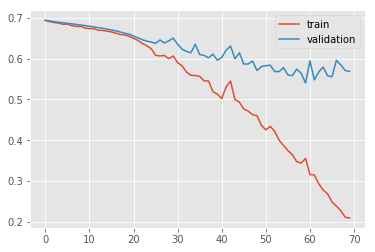

In [106]:
plt.plot(train_data.history['loss'], label='train')
plt.plot(train_data.history['val_loss'], label='validation')
plt.legend()
plt.show()

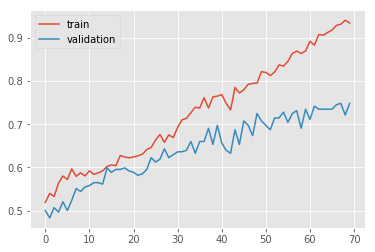

In [107]:
plt.plot(train_data.history['acc'], label='train')
plt.plot(train_data.history['val_acc'], label='validation')
plt.legend()
plt.show()

In [108]:
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(X_tst, ytst, verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(X_train, ytrain, verbose=0)))

Test loss 0.5818, acc 0.7458
Train loss 0.2083, acc 0.9497


#### 3 Class

In [109]:
data = list(data3C)

EMBEDDING_DIM = 200

examples = [x[0] for x in data]

model = gensim.models.Word2Vec(sentences=examples, size=EMBEDDING_DIM, window=5, min_count=5, workers=2, iter=5)
words = list(model.wv.vocab)
print(len(words))
print(model.wv.most_similar('dobar'))

model.wv.save_word2vec_format('word2vec_3_class.txt')

14438
[(u'lo\u0161', 0.8803110122680664), (u'dobiti', 0.7530609369277954), (u'vrhunski', 0.7516863346099854), (u'slab', 0.7464247345924377), (u'redak', 0.7418697476387024), (u'bitan', 0.7414994239807129), (u'solidan', 0.7390577793121338), (u'kvalitetan', 0.7388045191764832), (u'pomenuti', 0.7325552105903625), (u'pozitivan', 0.7285311222076416)]


In [0]:
wordvectors = {}
with open('word2vec_3_class.txt') as f:
  vocab_size = int(f.readline().split()[0])
  
  for line in f:
    vals = line.split()
    wordvectors[vals[0]] = np.asarray(vals[1:], dtype=np.float)

In [111]:
data = data_3_class.copy()
tokenizer = Tokenizer()

all_examples = data['Xtrain'] + data['Xtst'] + data['Xval']
all_labels = list(map(lambda x: 0 if x == -1 else 1, data['ytrain'] + data['ytst'] + data['yval']))
tokenizer.fit_on_texts(all_examples)
seq = tokenizer.texts_to_sequences(all_examples)

longest_example = max([len(x.split()) for x in all_examples])
vocab_size = len(tokenizer.word_index) + 1

seq_padded = pad_sequences(seq, maxlen=longest_example)

print('Unique tokens', len(tokenizer.word_index))
print('padded', seq_padded.shape)
# model.fit([x[0] for x in data2C[:5]], [x[1] for x in data2C[:5]], verbose=2)

('Unique tokens', 58435)
('padded', (2523, 1831))


In [112]:
print(seq[0], all_labels[0])
print(model.wv.most_similar(tokenizer.index_word.items()[1127][1]))
print(data['Xtrain'][0])

([7, 1, 726, 161, 4, 434, 798, 938, 922, 14424, 2, 12572, 17004, 4508, 9191, 21006, 165, 1, 9, 364, 20, 85, 219, 8, 9, 258, 12, 1, 137, 7, 22, 81, 11179, 4351, 80, 750, 498, 912, 21, 16, 32, 336, 2326, 7819, 36, 1633, 21007, 11180, 1, 4, 9, 10, 22, 33, 6, 1, 8, 1022, 183, 4, 1022, 67, 1482, 1, 15, 43, 6, 2671, 2030, 4351, 2327, 44, 3, 15, 2030, 91, 3, 326, 2975, 9, 33, 336, 6452, 21008, 15, 129, 1, 3, 77, 61, 3, 22, 410, 1244, 202, 152, 1999, 1286, 49, 17, 4, 322, 120, 14, 360, 2, 260, 33, 6, 1, 4, 1083, 107, 17, 3, 11, 1, 18, 9, 163, 86, 9, 22, 410, 603, 52, 68, 35, 1055, 1, 1349, 38, 1055, 21009, 21010, 4, 7, 7820, 5299, 42, 147, 4, 1582, 330, 66, 12, 17, 4, 27, 4509, 7, 77, 1, 556, 1185, 454, 60, 414, 291, 36, 87, 2061, 3120, 17, 2, 1614, 14425, 227, 4, 2379, 4202, 12573, 7317, 54, 21, 831, 58, 1, 10, 1, 5, 402, 962, 2, 122, 923, 33, 13, 180, 70, 16, 32, 206, 2, 1157, 771, 281, 1718, 1583, 153, 29, 1, 154, 1116, 546, 85, 27, 2328, 52, 65, 27, 460, 1326, 14, 7, 84, 1, 61, 22, 64, 30,

In [0]:
X_train = pad_sequences(tokenizer.texts_to_sequences(data['Xtrain']), maxlen=longest_example)
X_tst = pad_sequences(tokenizer.texts_to_sequences(data['Xtst']), maxlen=longest_example)
X_val = pad_sequences(tokenizer.texts_to_sequences(data['Xval']), maxlen=longest_example)

ytrain = to_categorical(data['ytrain'], num_classes=3)
ytst = to_categorical(data['ytst'], num_classes=3)
yval = to_categorical(data['yval'], num_classes=3)

In [0]:
print(np.unique(yval == [0, 0, 1], return_counts=True))
for i in yval:
  print(i)

In [115]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM + 1))

for word, i in tokenizer.word_index.items():
  if i > vocab_size:
    continue
  embd = wordvectors.get(word)
  if embd is not None:
    embedding_matrix[i] = np.append(embd, lexicon.get(word, 0))
    
print (np.shape(embedding_matrix))

(58436, 201)


In [135]:
model = Sequential()
embedding_layer = Embedding(vocab_size, EMBEDDING_DIM + 1, embeddings_initializer=Constant(embedding_matrix), input_length=longest_example, trainable=True)
model.add(embedding_layer)
# model.add(CuDNNGRU(units=256))
# # model.add(Dense(1, activation='elu'))
# # model.add(Bidirectional(CuDNNLSTM(256, return_sequences=True)))
# model.add(Dropout(0.5))
# # model.add(Dense(250, activation='sigmoid'))
# model.add(Dense(1, activation='sigmoid'))

# model.add(Conv1D(8, 5, activation='relu'))
# model.add(MaxPool1D(5))
# model.add(Conv1D(32, 5, activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPool1D(5))
# model.add(Conv1D(512, 5, activation='relu'))
# model.add(Dropout(0.5))
# model.add(MaxPool1D(20))

# model.add(Flatten())
model.add(Bidirectional(CuDNNLSTM(348)))
# model.add(Dense(1000, activation='relu'))
# model.add(Dense(200, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))
# mozda treba uzeti maksimlanu velicinu primera


adamax = Adamax(lr=0.0001)
rmsprop = RMSprop(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adamax, metrics=['acc'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 1831, 201)         11745636  
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 696)               1533984   
_________________________________________________________________
dropout_18 (Dropout)         (None, 696)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 2091      
Total params: 13,281,711
Trainable params: 13,281,711
Non-trainable params: 0
_________________________________________________________________
None


In [136]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('2_class_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(X_train, ytrain, validation_data=[X_val, yval], epochs=200, batch_size=128, verbose=1, callbacks=[es, chpt])

Train on 1639 samples, validate on 442 samples
Epoch 1/200
1639/1639 [==============================] - 18s 11ms/step - loss: 1.1009 - acc: 0.3429 - val_loss: 1.0979 - val_acc: 0.3620

Epoch 00001: val_acc improved from -inf to 0.36199, saving model to 2_class_model.h5
Epoch 2/200
1639/1639 [==============================] - 13s 8ms/step - loss: 1.0950 - acc: 0.3624 - val_loss: 1.0986 - val_acc: 0.3258

Epoch 00002: val_acc did not improve from 0.36199
Epoch 3/200
1639/1639 [==============================] - 13s 8ms/step - loss: 1.0935 - acc: 0.3661 - val_loss: 1.0986 - val_acc: 0.3213

Epoch 00003: val_acc did not improve from 0.36199
Epoch 4/200
1639/1639 [==============================] - 13s 8ms/step - loss: 1.0910 - acc: 0.3758 - val_loss: 1.0987 - val_acc: 0.3348

Epoch 00004: val_acc did not improve from 0.36199
Epoch 5/200
1639/1639 [==============================] - 13s 8ms/step - loss: 1.0872 - acc: 0.3832 - val_loss: 1.0993 - val_acc: 0.3213

Epoch 00005: val_acc did not imp

In [141]:
plt.plot(train_data.history['loss'], label='train')
plt.plot(train_data.history['val_loss'], label='validation')
plt.legend()
plt.show()

AttributeError: ignored

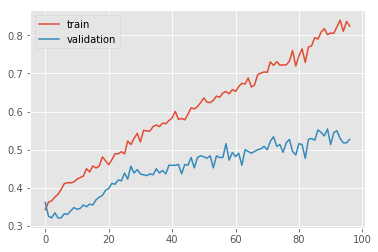

In [138]:
plt.plot(train_data.history['acc'], label='train')
plt.plot(train_data.history['val_acc'], label='validation')
plt.legend()
plt.show()

In [21]:
model = load_model('3_class_model.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(X_tst, ytst, verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(X_train, ytrain, verbose=0)))

NameError: ignored

# Other

In [18]:
model, data = get_model(3, data3C, data_3_class, 100, 5, 5)
es = EarlyStopping(monitor='val_loss', mode='min', verbose='1', patience=50)
chpt = ModelCheckpoint('3_class_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
with tf.device('/gpu:0'):
  train_data = model.fit(data[0], data[3], validation_data=[data[2], data[5]], epochs=200, batch_size=128, verbose=1, callbacks=[es, chpt])

('Vocabulary size:', 14438)
('Longest review', 1831)
('Unique tokens', 58435)
('padded', (2523, 1831))
('Embedding size', (58436, 101))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1831, 101)         5902036   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 512)               735232    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 6,638,807
Trainable params: 6,638,807
Non-trainable params: 0
_________________________________________________________________
None
Train on 1639 samples, validate on 442 samples
Epoch 1/200
1639/1639 [==============================] - 8s 5ms/step - loss:

KeyboardInterrupt: ignored

In [22]:
model = load_model('3_class_model.h5')
print('Test loss %.4f, acc %.4f' % tuple(model.evaluate(data[1], data[4], verbose=0)))
print('Train loss %.4f, acc %.4f' % tuple(model.evaluate(data[0], data[3], verbose=0)))

Test loss 1.0822, acc 0.4072
Train loss 0.9691, acc 0.5259
